# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

### Tecnológico de Monterrey


## **Actividad de la Semana 02**
### **EDA de los conjuntos de datos seleccionados**


Equipo 32

José Adan Vega Pérez [A01796093]

Silvia Xochitl Ibañez Vara [A01795200]

Diego Andrés Bernal Díaz [A01795975]



## Obtencion de los datasets Wordnet18 y Freebase 15k de pytorch-geometric

In [ ]:
import torch

print("Torch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("Versión CUDA:", torch.version.cuda)

assert torch.cuda.is_available(), ("No GPU. Set Runtime → Change runtime type → GPU")

In [ ]:
import torch

try:
    import torch_geometric
except ModuleNotFoundError:
    torch_version = torch.__version__.split("+")[0]
    cuda_version = torch.version.cuda.replace(".", "")

    !pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv \
        -f https://data.pyg.org/whl/torch-{torch_version}+cu{cuda_version}.html

    !pip install -q torch-geometric


In [ ]:
import torch
import torch_geometric

print("Torch:", torch.__version__)
print("Torch Geometric:", torch_geometric.__version__)


In [ ]:
from pathlib import Path

# Rutas base
PYG_DIR = Path("./pyg_temp")     # Carpeta temporal para descargas de PyG
FINAL_DATA_DIR = Path("./data")  # Carpeta de datos principal

# Crear carpetas si no existen (idempotente)
for directory in [PYG_DIR, FINAL_DATA_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("Estructura de carpetas verificada:")
print(f"- PYG_DIR: {PYG_DIR.resolve()}")
print(f"- FINAL_DATA_DIR: {FINAL_DATA_DIR.resolve()}")


In [ ]:
import os
import shutil
import pandas as pd
from torch_geometric.datasets import WordNet18RR, FB15k_237

# --- CONFIGURACIÓN ---
PYG_DIR = "./pyg_temp"  # Carpeta temporal para descargas de PyG
FINAL_DATA_DIR = "./data" # Tu carpeta de datos principal

def standard_to_txt(pyg_dataset, dataset_name):
    """
    Toma los archivos raw descargados por PyG y los mueve a tu carpeta ./data
    en formato limpio (head, relation, tail).
    """
    raw_dir = pyg_dataset.raw_dir
    target_dir = os.path.join(FINAL_DATA_DIR, dataset_name)
    os.makedirs(target_dir, exist_ok=True)

    print(f"\nProcesando {dataset_name} desde {raw_dir}...")

    # Mapeo de nombres de archivos de PyG a nombres estándar
    # PyG a veces usa 'train.txt', a veces otros nombres.
    files_map = {
        'train': ['train.txt'],
        'valid': ['valid.txt', 'valid.csv'],
        'test': ['test.txt']
    }

    for split, possible_names in files_map.items():
        found = False
        for fname in possible_names:
            src_path = os.path.join(raw_dir, fname)
            if os.path.exists(src_path):
                found = True
                dst_path = os.path.join(target_dir, f"{split}.txt")

                # Leemos con Pandas para asegurarnos de limpiar headers o índices extra
                try:
                    # FB15k-237 y WN18RR raw suelen venir separados por tabs o espacios
                    df = pd.read_csv(src_path, sep=None, engine='python', header=None, on_bad_lines='skip')

                    # Quedarnos con las primeras 3 columnas (Head, Rel, Tail)
                    # OJO: FB15k-237 a veces viene como (Head, Tail, Rel) o (Head, Rel, Tail)
                    # En los raw files de PyG estándar suele ser: Head, Relation, Tail (Strings)
                    if df.shape[1] >= 3:
                        df = df.iloc[:, :3]

                        # Guardamos en formato limpio separado por comas o tabs
                        df.to_csv(dst_path, sep=',', index=False, header=False)
                        print(f"  -> {split}.txt guardado en {target_dir} ({len(df)} filas)")
                    else:
                        print(f"  [!] Estructura extraña en {fname}: {df.shape}")

                except Exception as e:
                    print(f"  [Error] al procesar {fname}: {e}")
                break

        if not found:
            print(f"  [X] No se encontró archivo para split '{split}'")

# --- 1. DESCARGAR WN18RR ---
print("--- Descargando WordNet18RR usando PyG ---")
# Esto descargará automáticamente los archivos a ./pyg_temp/WordNet18RR/raw
dataset_wn = WordNet18RR(root=os.path.join(PYG_DIR, "WordNet18RR"))
standard_to_txt(dataset_wn, "WN18RR")

# --- 2. DESCARGAR FB15k-237 ---
print("--- Descargando FB15k-237 usando PyG ---")
# Esto descargará automáticamente los archivos a ./pyg_temp/FB15k_237/raw
dataset_fb = FB15k_237(root=os.path.join(PYG_DIR, "FB15k-237"))
standard_to_txt(dataset_fb, "FB15k-237")

print("\n--- ¡LISTO! ---")
print(f"Ahora tienes WN18RR y FB15k-237 en la carpeta '{FINAL_DATA_DIR}' con el mismo formato que el resto.")

## Obtencion del resto de datasets de repositorios de github

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests

# Set style for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# --- CONFIGURATION (CORRECTED URLS) ---
DATA_DIR = "./data"

DATASETS = {
    "CoDEx-M": {
        "base_url": "https://raw.githubusercontent.com/tsafavi/codex/master/data/triples/codex-m/",
        "files": ["train.txt", "valid.txt", "test.txt"]
    },
    "WN11": {
        "base_url": "https://raw.githubusercontent.com/KGCompletion/TransL/master/WN11/",
        "files": ["train.txt", "valid.txt", "test.txt"]
    },
    "FB13": {
        "base_url": "https://raw.githubusercontent.com/KGCompletion/TransL/master/FB13/",
        "files": ["train.txt", "valid.txt", "test.txt"]
    }
}






# --- HELPER FUNCTIONS ---
def download_file(url, save_path):
    """Downloads a file from a URL if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {save_path}...")
        try:
            r = requests.get(url)
            r.raise_for_status()
            with open(save_path, 'wb') as f:
                f.write(r.content)
            print(f"  -> Success!")
        except Exception as e:
            print(f"  -> Failed to download {url}: {e}")
    else:
        print(f"Found local: {save_path}")

def load_dataset(name, config):
    """Loads train/valid/test into a dictionary of DataFrames."""
    path = os.path.join(DATA_DIR, name)
    os.makedirs(path, exist_ok=True)

    dfs = {}
    for file_name in config["files"]:
        # 1. Download
        url = config["base_url"] + file_name
        local_path = os.path.join(path, file_name)
        download_file(url, local_path)

        # 2. Load to Pandas
        # Try-catch to handle potential parsing issues
        try:
            # We use engine='python' and sep=None to auto-detect tab or space separators
            # This makes it robust against different format standards
            df = pd.read_csv(local_path, sep=None, engine='python',
                             names=['head', 'relation', 'tail'],
                             on_bad_lines='skip')

            # Clean up: Sometimes the last column has a 4th value (label 1/-1) in older datasets
            # For EDA we usually just want the triplet. Let's check shape.
            if df.shape[1] > 3:
                df = df.iloc[:, :3]
                df.columns = ['head', 'relation', 'tail']

            dfs[file_name.replace('.txt', '')] = df
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    return dfs

# --- EXECUTION ---
print("--- STARTING DATA LOADING ---")
kg_data = {}

for ds_name, config in DATASETS.items():
    print(f"\nProcessing {ds_name}...")
    kg_data[ds_name] = load_dataset(ds_name, config)

    # Quick Sanity Check
    if 'train' in kg_data[ds_name]:
        count = len(kg_data[ds_name]['train'])
        print(f"  -> Loaded {ds_name} Train: {count} triplets")
        print(f"  -> Sample: {kg_data[ds_name]['train'].iloc[0].values}")

print("\n--- READY FOR EDA ---")

# 1. Macro-Estadisticas

Before diving deep, you need a high-level comparison table. This establishes the scale.

    Metrics:
        Total Entities
        Total Relations
        Total Triplets
        Split distribution: Count of Train / Validation / Test triples.
        Graph Density: (Is the graph sparse or dense?).
        Average Degree: On average, how many connections does a node have?

    Why it matters: Sparse graphs (like WordNet) are harder for GNNs (Graph Neural Networks) because there is less "message passing."

In [ ]:
import os
import pandas as pd
import glob

def calculate_macro_stats(base_dir="./data"):
    stats_list = []

    # Get all subdirectories in ./data
    dataset_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    print(f"Found datasets: {dataset_names}")

    for name in dataset_names:
        ds_path = os.path.join(base_dir, name)

        # Initialize sets to track unique entities and relations across ALL splits
        all_entities = set()
        all_relations = set()

        split_counts = {'train': 0, 'valid': 0, 'test': 0}
        total_triples = 0

        # Process each split
        for split in ['train', 'valid', 'test']:
            file_path = os.path.join(ds_path, f"{split}.txt")

            if os.path.exists(file_path):
                try:
                    # Robust loading: handles comma, tab, or space separators automatically
                    df = pd.read_csv(file_path, sep=None, engine='python', header=None, on_bad_lines='skip')

                    # Ensure we have at least 3 columns
                    if df.shape[1] >= 3:
                        # Extract Head, Relation, Tail (assuming 0=Head, 1=Rel, 2=Tail based on standard formats)
                        # NOTE: Some datasets are H, T, R. Others H, R, T.
                        # For simply COUNTING entities/relations, column order doesn't matter much
                        # as long as we grab the entities and relation columns.
                        # We assume standard H, R, T or H, T, R. We'll take col 1 as relation mostly.
                        # But to be safe for counts, we treat the "middle" as relation usually,
                        # or we can check unique counts to guess, but let's stick to standard H, R, T logic here.

                        heads = df.iloc[:, 0].astype(str)
                        rels = df.iloc[:, 1].astype(str)
                        tails = df.iloc[:, 2].astype(str)

                        # Update counts
                        count = len(df)
                        split_counts[split] = count
                        total_triples += count

                        # Update Unique Sets
                        all_entities.update(heads.unique())
                        all_entities.update(tails.unique())
                        all_relations.update(rels.unique())

                except Exception as e:
                    print(f"Error reading {name}/{split}: {e}")

        # Calculate Derived Metrics
        num_entities = len(all_entities)
        num_relations = len(all_relations)

        # Avoid division by zero
        if num_entities > 0:
            # Avg Degree = Triples / Entities
            avg_degree = total_triples / num_entities

            # Density = Triples / (Entities * (Entities - 1))  [Directed Graph]
            density = total_triples / (num_entities * (num_entities - 1))
        else:
            avg_degree = 0
            density = 0

        stats_list.append({
            'Dataset': name,
            'Entities (|E|)': num_entities,
            'Relations (|R|)': num_relations,
            'Triples (Total)': total_triples,
            'Train': split_counts['train'],
            'Valid': split_counts['valid'],
            'Test': split_counts['test'],
            'Avg Degree': round(avg_degree, 4),
            'Graph Density': density # Keep distinct to see scientific notation if needed
        })

    # Create DataFrame
    df_stats = pd.DataFrame(stats_list)

    # Set Dataset as index
    if not df_stats.empty:
        df_stats = df_stats.set_index('Dataset')

    return df_stats

# --- EXECUTE ---
df_macro_stats = calculate_macro_stats()

# Display formatted table
# We use style to format the Density column because it is usually very small (e.g., 0.0001)
display(df_macro_stats.style.format({
    'Graph Density': '{:.6f}',
    'Avg Degree': '{:.2f}'
}))

# 2. Análisis de relaciones

Knowledge Graphs rarely have balanced relations. Some relations are incredibly common (e.g., gender), others are rare.

    Analysis:

        Frequency Histogram: Plot the count of triplets per relation.

        Head vs. Tail Relations: Identify which relations make up the top 50% of the data.

    Relevance to Project: If you are extrapolating, it is easier to predict a common relation for a new node than a rare one. If CoDEx-M is more balanced than FB13, your model might perform more consistently there.

# 3. Node Degree Distribution (The "Hubs" Analysis)

This is crucial for graph embeddings. Real-world graphs follow a Power Law (Long Tail).

    Analysis:

        Plot the distribution of node degrees (log-log scale).

        Identify "Hubs" (super-connected nodes, like "USA" in Freebase) vs. "Tail Entities" (nodes with 1 or 2 connections).

    Relevance to Extrapolation (CRITICAL):

        Hypothesis: New entities (unseen) that connect to Hubs are easier to embed because the Hub has a stable, rich representation. New entities that connect only to other sparse nodes are extremely hard to predict.

        Action: Check what percentage of entities in WN11/FB13 have a degree <3

# 4. Connectivity Patterns (The "Structure" Analysis)

Since WN11 comes from WordNet (hierarchy) and FB13 from Freebase (facts), their shapes are different.

    Analysis:

        Clustering Coefficient: Do neighbors of a node know each other? (Triangles).

        Diameter / Average Path Length: How many hops to get from node A to node B?

    Relevance:

        WN11: Likely has low clustering (tree structure, hierarchies don't form many triangles).

        FB13/CoDEx: Likely higher clustering (social networks, movies). GNNs behave differently on trees vs. clustered graphs.

# 5. The "Inductive Bias" Analysis (The Most Important for You)

Since your project is about unseen entities, you must analyze the "gap" between Train and Test. Standard EDAs don't do this, but you must.

A. Unseen Entity Ratio (if using standard splits):

    In the Test set, how many entities are strictly new?

    (Note: If you use the specific benchmarks from Hamaguchi et al. or GraIL, this is 100%, but you should verify it).

B. "Connectivity to Known" Ratio:

    For the triples in the Test set (involving new entities), who are they connected to?

        Scenario A: New Entity

        Old Entity (Seen in Train).

        Scenario B: New Entity


        New Entity.

    Why it matters:

        Scenario A is "Transductive-Inductive". Easier. The model uses the Old Entity as an anchor.

        Scenario B is "Fully Inductive". Extremely hard. If a new node only connects to another new node, the model is "blind."

    The Chart: A bar chart showing the % of test triples that connect to Seen vs. Unseen nodes.

# 6. Text/Semantics Analysis (Optional but recommended)

Since you mentioned using "descriptions" or "external info" for extrapolation.

    Analysis: Calculate the average length of text descriptions for entities in CoDEx vs FB13.

    Relevance: If FB13 has rich text and WN11 has short definitions, your text-based extrapolation model might work better on FB13.

# Estructura de los datos

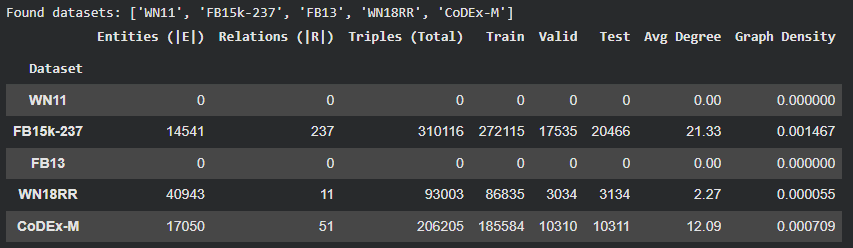

1. Descripción del dataset
   - entidades
   - relaciones
   - tripletas
   - cardinalidad por split
   - tipo de dato (categórico, simbólico)

2. Estadísticas estructurales
   - grado promedio
   - densidad
   - tripletas por entidad
   - tripletas por relación

3. Frecuencias de relaciones
   - tabla
   - top 10 + cola larga

4. Valores faltantes
   - NO aplica: En los grafos de conocimiento no existen valores faltantes en el sentido tabular clásico, ya que cada registro corresponde a una relación completa entre dos entidades. La “información incompleta” se manifiesta únicamente de forma estructural mediante nodos con baja conectividad, lo cual se analiza posteriormente en la sección de conectividad del grafo


# Análisis univariante

El proyecto.
1. Histograma de grados de entidades
2. Gráfico de barras de frecuencia de relaciones
3. Distribución del número de tripletas por entidad
4. Top-N hubs (barplot)

Boxplots no aplican (no hay datos continuos):

Dado que las variables del grafo son categóricas y no contienen atributos numéricos continuos, no se emplean boxplots. En su lugar, se utilizan histogramas y gráficos de barras sobre métricas estructurales (grado, frecuencia de relaciones), que son las representaciones adecuadas para este tipo de datos


# Análisis bi/multivariante

Justificar que no tenemos multiples variables, solo tripletas.


# Preprocesamiento

WordNet18RR a triplets


# Conclusiones

Se incluyen las ideas/observaciones clave, asegurándose de responder todas las preguntas propuestas que apliquen al proyecto.
